## Ridge Regression project code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from category_encoders import TargetEncoder

In [2]:
df = pd.read_csv(r'dataset.csv')

cat_fields = ['artists','album_name','track_name','track_genre','key','mode','explicit']
num_fields = ['popularity','duration_ms','danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']
# both_fields = ['popularity','duration_ms','danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','artists','album_name','track_name','explicit','track_genre', 'key','mode', 'time_signature']

Checking basic data properties, distributions

In [3]:
df.head(10)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,...,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,...,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,...,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,...,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,...,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


In [4]:
#df.describe

In [5]:
# for column in num_fields:
#     plt.figure()
#     df[column].plot.hist(bins=10)
#     plt.title(column)
#     plt.xlabel('value')
#     plt.ylabel('frequency')
#     plt.show()

## Preprocessing and Encoding

In [6]:
df['explicit'] = df['explicit'].replace({True: 1, False: 0})
df.drop("Unnamed: 0", axis=1, inplace=True)
#df.head()

As genres create many row duplicates -> first encode them (OHE), then erase duplicated rows


In [7]:
genre_counts = df['track_genre'].value_counts(normalize=True)
pd.set_option('display.max_rows', None)
#print(genre_counts)
# the genres are evenely spread

In [8]:
genre_mean_popularity = df.groupby('track_genre')['popularity'].mean()
#print(genre_mean_popularity)

In [9]:
low = 26
high = 41
df['genre_cat'] = df['track_genre'].map(genre_mean_popularity)
df['genre_cat'] = pd.cut(df['genre_cat'],
                                   bins=[0, low, high, 100],
                                   labels=['low', 'medium', 'high'],
                                   right=False)
df = pd.get_dummies(df, columns = ['genre_cat'])

In [10]:
df = df.drop_duplicates(subset='track_id')
#df.shape

Replacing artists with frequency encoding

In [11]:
df['artists_2'] = df['artists'].str.split(';').str[1]
df['artists'] = df['artists'].str.split(';').str[0]
df['artists_2'].fillna(0, inplace=True)
df.head()

count = df['artists'].str.contains(';').sum()
#print(count)
# if 0 -> good, everything is split up

In [12]:
combined_artists = pd.DataFrame({
        'artists': df['artists'].tolist() + df['artists_2'].tolist(),
        'popularity': df['popularity'].tolist() + df['popularity'].tolist()
    })

#print(combined_artists)

In [13]:
combined_artists = pd.concat([df['artists'], df['artists_2']])
artist_counts = combined_artists.value_counts(normalize=True).reset_index()
artist_counts.columns = ['artists', 'count']
popularity_df = df.groupby(['artists'])['popularity'].mean().reset_index()
popularity_df.columns = ['artists', 'mean_popularity']
final_df = pd.merge(artist_counts, popularity_df, on='artists')
# final_df.head(20)

Now we create a frequency encoding to create a variable which conveys the amount of different songs written by an artist (the higher the number, the longer/more fruitful their career has been).

In [14]:
artist_count = final_df.set_index('artists')['count'].to_dict()
df['artist_num'] = df['artists'].map(artist_count)
#df.head()

In [15]:
quartiles = final_df['mean_popularity'].quantile([0.25, 0.5, 0.75])
# print("1 quartile:", quartiles[0.25])
# print("2 quartile:", quartiles[0.5])
# print("3 quartile:", quartiles[0.75])

In [16]:
def categorize_popularity(popularity):
    if popularity < 24:
        return 'low'
    elif popularity < 48:
        return 'medium'
    else:
        return 'high'
final_df['popularity_group'] = final_df['mean_popularity'].apply(categorize_popularity)
#print(final_df)

In [17]:
artist_to_popularity_group = final_df.set_index('artists')['popularity_group'].to_dict()
df['artists'] = df['artists'].map(artist_to_popularity_group)
df = pd.get_dummies(df, columns = ['artists'])

Encoding albums (frequency encoding)

In [18]:
album_dict = df['album_name'].value_counts().to_dict()
df['album_name'] = df['album_name'].replace(album_dict)

In [19]:
album_counts = df['album_name'].value_counts(normalize=True)
df['album_en'] = df['album_name'].map(album_counts)

Replacing track names with target encoding

In [20]:
track_counts = df['track_name'].value_counts()
mean_count = track_counts.mean()
#print(mean_count)

In [21]:
smoothing = 1.2
te = TargetEncoder(smoothing=smoothing)
df['track_en'] = te.fit_transform(df['track_name'], df['popularity'])

In [22]:
df= df.drop(['track_id','album_name','track_name','artists_2'], axis=1)

In [23]:
df= df.drop(['track_genre'], axis=1)
# df= df.drop(['artists_high','artists_medium','artists_low'], axis=1)

In [24]:
nan_counts = df.isnull().sum()
# print(nan_counts)
df.dropna(inplace=True)

Rescaling the remaining variables

In [25]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])

In [26]:
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,time_signature,genre_cat_low,genre_cat_medium,genre_cat_high,artist_num,artists_high,artists_low,artists_medium,album_en,track_en
0,0.46,-0.915054,-1.0,0.372589,-0.0780,-0.818182,0.582783,-1.0,-0.703627,-0.935341,...,0.6,-1.0,-1.0,1.0,-0.963746,1.0,-1.0,-1.0,1.000000,0.484363
1,0.10,-0.946058,-1.0,-0.147208,-0.6680,-0.818182,0.194754,1.0,-0.841865,0.855422,...,0.6,-1.0,-1.0,1.0,-0.951662,-1.0,-1.0,1.0,1.000000,0.484363
2,0.14,-0.922642,-1.0,-0.110660,-0.2820,-1.000000,0.472245,1.0,-0.884560,-0.578313,...,0.6,-1.0,-1.0,1.0,-0.939577,1.0,-1.0,-1.0,1.000000,0.484363
3,0.42,-0.926044,-1.0,-0.459898,-0.8808,-1.000000,0.147402,1.0,-0.924767,0.817269,...,0.2,-1.0,-1.0,1.0,-0.885196,1.0,-1.0,-1.0,1.000000,0.484367
4,0.64,-0.927222,-1.0,0.254822,-0.1140,-0.636364,0.474206,1.0,-0.890984,-0.058233,...,0.6,-1.0,-1.0,1.0,-0.933535,-1.0,-1.0,1.0,-0.797346,0.517208


Checking for Nan

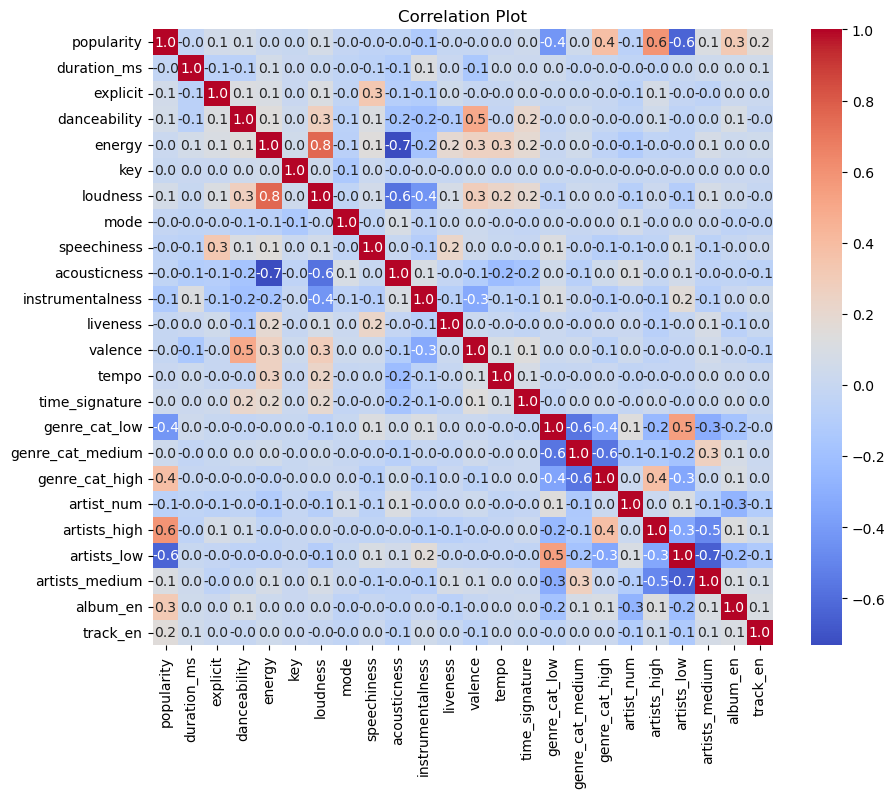

In [27]:
correlation_matrix2 = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix2, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Correlation Plot")
plt.show()

Creating a dataframe only containing numerical features

In [28]:
scaled_df = df[num_fields]

## Model 1: Ridge Regression - No CV, numerical variables only

In [29]:
class ridgereg:
    def __init__(self, alpha):
        self.alpha = alpha
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        XtX = np.dot(X.T, X)
        n = X.shape[1]
        self.coef_ = np.dot(np.linalg.inv(XtX + self.alpha * np.eye(n)), np.dot(X.T, y))
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]

        return self

    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        return np.dot(X, np.concatenate(([self.intercept_], self.coef_)))

Splitting into test-train sets.

In [30]:
X = scaled_df.iloc[:, 1:].values
Y = scaled_df.iloc[:, 0].values

ratio = 0.7
total_rows = X.shape[0]
train_size = int(total_rows * ratio)

X_train = X[0:train_size]
X_test = X[train_size:]

total_rows = Y.shape[0]
train_size = int(total_rows * ratio)

Y_train = Y[0:train_size]
Y_test = Y[train_size:]

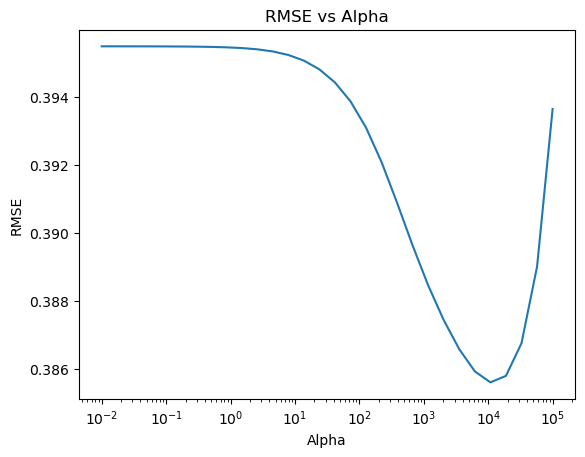

R2 Score: -0.056956594030533436
Best Alpha: 10826.36733874054
Best RMSE: 0.38559781916682234


In [31]:
alphas = np.logspace(-2, 5, num=30)

rmse_scores = []
r2_scores = []

for alpha in alphas:
    model = ridgereg(alpha=alpha)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    rmse_scores.append(rmse)

    r2 = r2_score(Y_test, y_pred)
    r2_scores.append(r2)

plt.plot(alphas, rmse_scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.show()

best_alpha_idx = np.argmin(rmse_scores)
best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores[best_alpha_idx]
best_r2 = r2_scores[best_alpha_idx]

print("R2 Score:", r2)
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

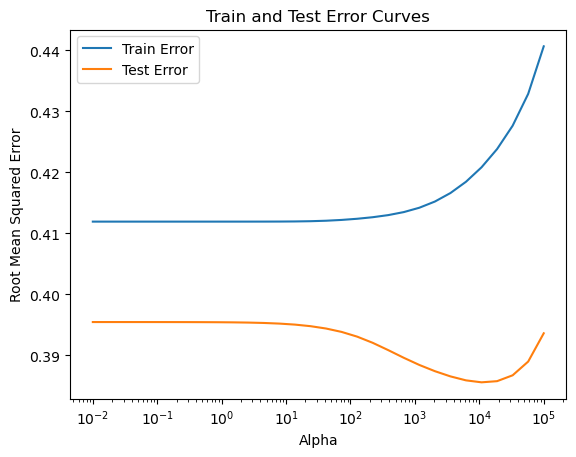

In [32]:
train_errors=[]
test_errors=[]

for alpha in alphas:
    model = ridgereg(alpha=alpha)
    model.fit(X_train, Y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    test_error = np.sqrt(mean_squared_error(Y_test, y_test_pred))

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.plot(alphas, train_errors, label='Train Error')
plt.plot(alphas, test_errors, label='Test Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.title('Train and Test Error Curves')
plt.legend()
plt.show()

## Numerical variables + 5-fold CV

In [33]:
class ridgeregCV(BaseEstimator, RegressorMixin):
    def __init__(self, alpha):
        self.alpha = alpha
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

        XtX = np.dot(X.T, X)
        n = X.shape[1]
        self.coef_ = np.dot(np.linalg.inv(XtX + self.alpha * np.eye(n)), np.dot(X.T, y))
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]

        return self

    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        return np.dot(X, np.concatenate(([self.intercept_], self.coef_)))

    def get_params(self, deep=True):
        return {'alpha': self.alpha}

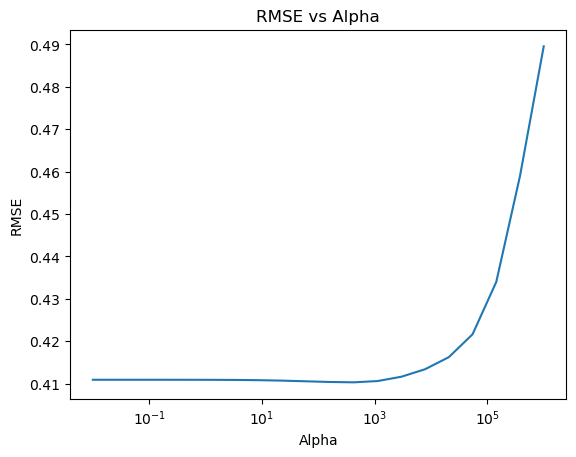

R2 Score: -0.056956594030533436
Best Alpha: 428.13323987193957
Best RMSE: 0.4102781926532983


In [34]:
alphas = np.logspace(-2, 6, num=20)

rmse_scores = []
r2_scores = []
for alpha in alphas:
    model = ridgeregCV(alpha=alpha)

    rmse_cv = np.sqrt(-cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=5))
    rmse_mean = np.mean(rmse_cv)

    r2_cv = cross_val_score(model, X, Y, scoring='r2', cv=5)
    r2_mean = np.mean(r2_cv)

    rmse_scores.append(rmse_mean)
    r2_scores.append(r2_mean)

plt.plot(alphas, rmse_scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.show()

best_alpha_idx = np.argmin(rmse_scores)
best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores[best_alpha_idx]
best_r2 = r2_scores[best_alpha_idx]

print("R2 Score:", r2)
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)


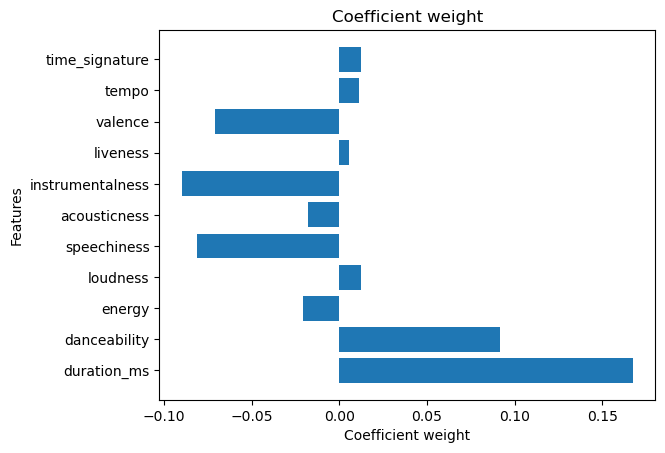

Best Alpha: 428.13323987193957
Best RMSE: 0.4102781926532983


In [35]:
best_model = ridgeregCV(alpha=best_alpha)
best_model.fit(X, Y)

feature_names = scaled_df.columns[1:]
coef = best_model.coef_

plt.barh(feature_names, coef)
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.title('Coefficient weight')
plt.show()

# Print the best alpha and best RMSE
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

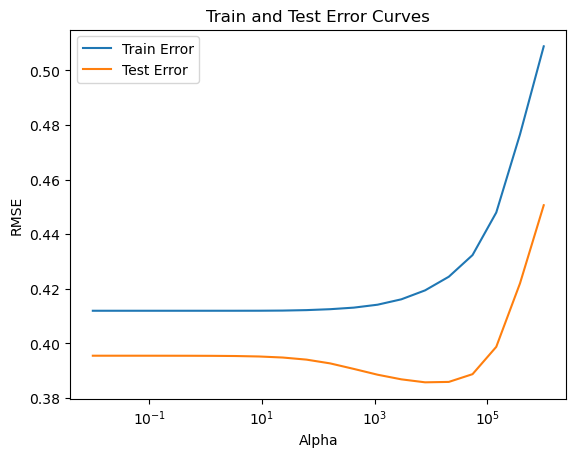

In [36]:
train_errors=[]
test_errors=[]

for alpha in alphas:
    model = ridgeregCV(alpha=alpha)
    model.fit(X_train, Y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    test_error = np.sqrt(mean_squared_error(Y_test, y_test_pred))

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.plot(alphas, train_errors, label='Train Error')
plt.plot(alphas, test_errors, label='Test Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Train and Test Error Curves')
plt.legend()
plt.show()

## Model 2: Adding categorical variables - No CV

Split data into train and test set

In [37]:
X = df.iloc[:, 1:].values
Y = df.iloc[:, 0].values

ratio = 0.7
total_rows = X.shape[0]
train_size = int(total_rows * ratio)

X_train = X[0:train_size]
X_test = X[train_size:]

total_rows = Y.shape[0]
train_size = int(total_rows * ratio)

Y_train = Y[0:train_size]
Y_test = Y[train_size:]

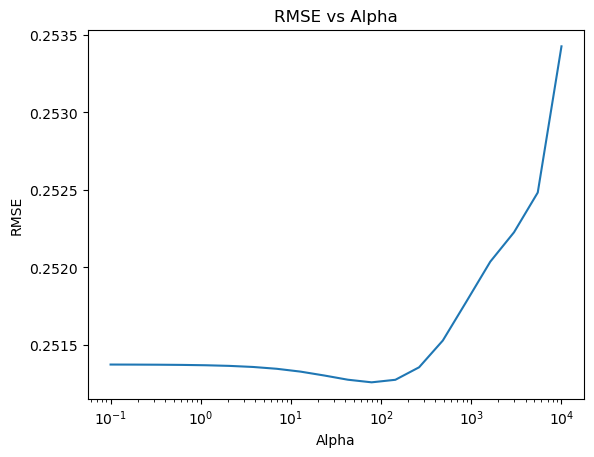

R2 Score: 0.5619012848822724
Best Alpha: 78.47599703514607
Best RMSE: 0.2512580827731033


In [38]:
alphas = np.logspace(-1, 4, num=20)
rmse_scores = []
r2_scores = []

for alpha in alphas:
    model = ridgereg(alpha=alpha)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    rmse_scores.append(rmse)
    
    r2 = r2_score(Y_test, y_pred)
    r2_scores.append(r2)

plt.plot(alphas, rmse_scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.show()

best_alpha_idx = np.argmin(rmse_scores)
best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores[best_alpha_idx]
best_r2 = r2_scores[best_alpha_idx]

print("R2 Score:", r2)
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

## Adding 5-fold CV

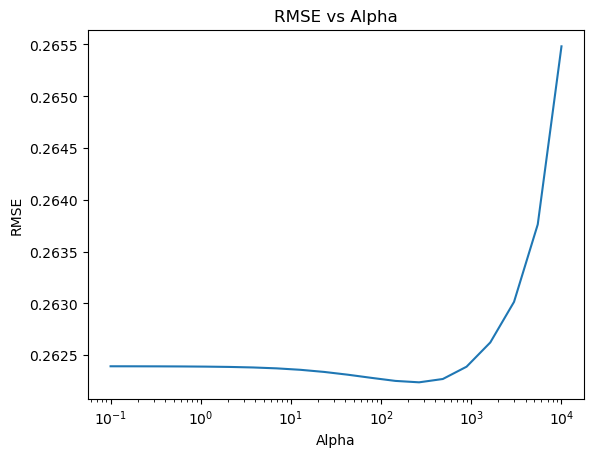

R2 Score: 0.5619012848822724
Best Alpha: 263.6650898730358
Best RMSE: 0.2622367244438032


In [39]:
alphas = np.logspace(-1, 4, num=20)
rmse_scores = []
r2_scores = []

for alpha in alphas:
    model = ridgeregCV(alpha=alpha)
    rmse_cv = np.sqrt(-cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=5))
    r2_cv = cross_val_score(model, X, Y, scoring='r2', cv=5)

    rmse_mean = np.mean(rmse_cv)
    rmse_scores.append(rmse_mean)

    r2_mean = np.mean(r2_cv)
    r2_scores.append(r2_mean)

plt.plot(alphas, rmse_scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.show()

best_alpha_idx = np.argmin(rmse_scores)

best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores[best_alpha_idx]
r2 = r2_score(Y_test, y_pred)

print("R2 Score:", r2)
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

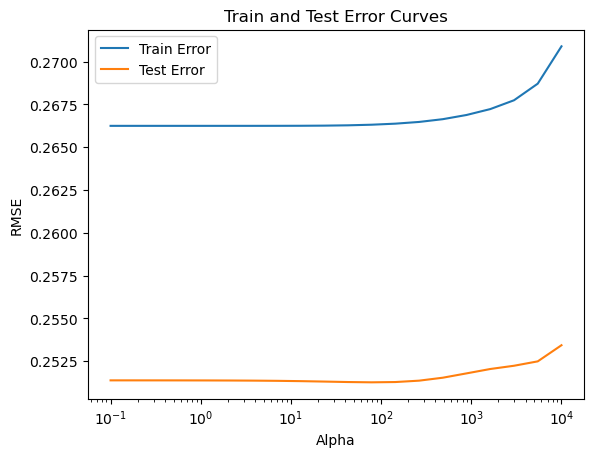

In [40]:
train_errors=[]
test_errors=[]

for alpha in alphas:
    model = ridgereg(alpha=alpha)
    model.fit(X_train, Y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    test_error = np.sqrt(mean_squared_error(Y_test, y_test_pred))

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.plot(alphas, train_errors, label='Train Error')
plt.plot(alphas, test_errors, label='Test Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Train and Test Error Curves')
plt.legend()
plt.show()

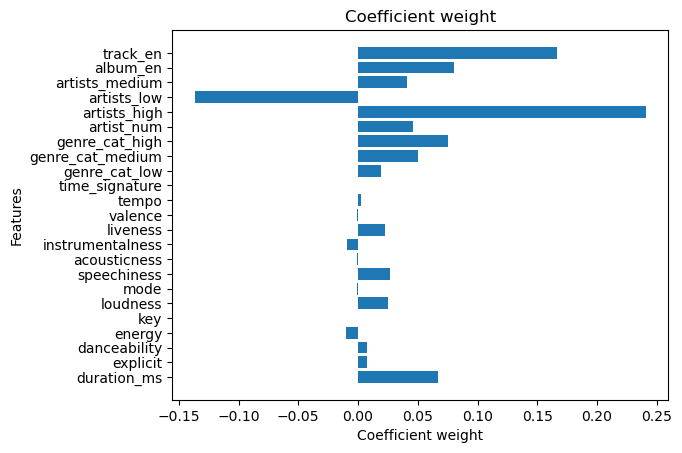

Best Alpha: 263.6650898730358
Best RMSE: 0.2622367244438032


In [41]:
best_model2 = ridgeregCV(alpha=best_alpha)
best_model2.fit(X, Y)

feature_names = df.columns[1:]
coef = best_model2.coef_

plt.barh(feature_names, coef)
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.title('Coefficient weight')
plt.show()

# Print the best alpha and best RMSE
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

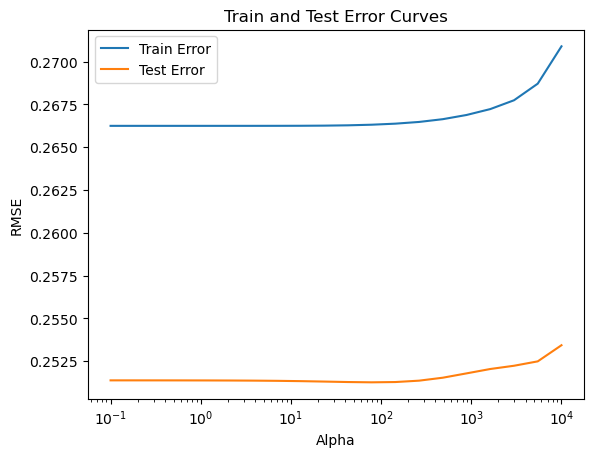

In [42]:
train_errors=[]
test_errors=[]

for alpha in alphas:
    model = ridgeregCV(alpha=alpha)
    model.fit(X_train, Y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    test_error = np.sqrt(mean_squared_error(Y_test, y_test_pred))

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.plot(alphas, train_errors, label='Train Error')
plt.plot(alphas, test_errors, label='Test Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Train and Test Error Curves')
plt.legend()
plt.show()

## Other models

### Excluding low-importance features

In [43]:
df2 = df.drop(['time_signature','mode','key','valence','tempo','acousticness'], axis =1)
X = df2.iloc[:, 1:].values
Y = df2.iloc[:, 0].values
ratio = 0.7
total_rows = X.shape[0]
train_size = int(total_rows * ratio)

X_train = X[0:train_size]
X_test = X[train_size:]
total_rows = Y.shape[0]
train_size = int(total_rows * ratio)

Y_train = Y[0:train_size]
Y_test = Y[train_size:]

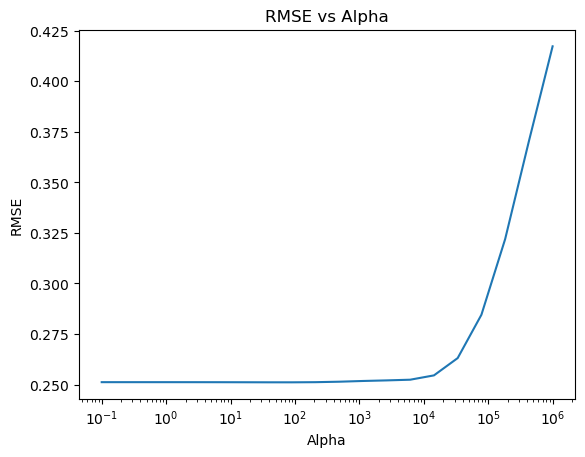

R2 Score: -0.18741047263277144
Best Alpha: 88.58667904100822
Best RMSE: 0.25114311099962755


In [44]:
alphas = np.logspace(-1, 6, num=20)
rmse_scores = []
r2_scores = []

for alpha in alphas:
    model_1 = ridgeregCV(alpha=alpha)
    model_1.fit(X_train, Y_train)
    y_pred = model_1.predict(X_test)

    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    rmse_scores.append(rmse)
    
    r2 = r2_score(Y_test, y_pred)
    r2_scores.append(r2)

plt.plot(alphas, rmse_scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.show()

best_alpha_idx = np.argmin(rmse_scores)
best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores[best_alpha_idx]
best_r2 = r2_scores[best_alpha_idx]

print("R2 Score:", r2)
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

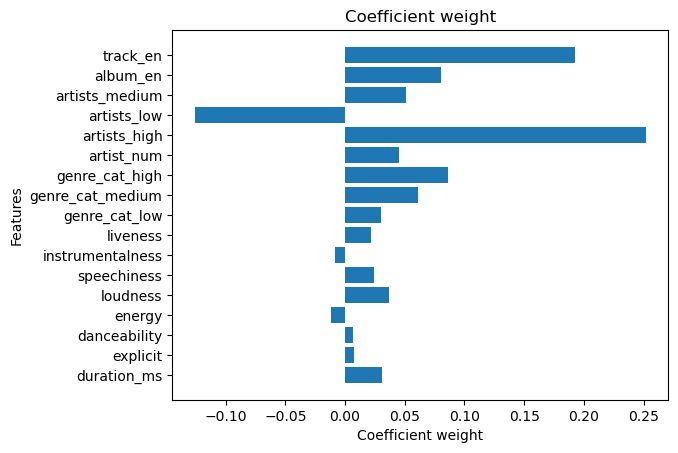

Best Alpha: 88.58667904100822
Best RMSE: 0.25114311099962755


In [45]:
best_model = ridgeregCV(alpha=best_alpha)
best_model.fit(X, Y)

feature_names = df2.columns[1:]
coef = best_model.coef_

plt.barh(feature_names, coef)
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.title('Coefficient weight')
plt.show()

print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

## Model 3: Excluding more num.vars + k-fold CV

In [46]:
df3 = df2.drop(['explicit','liveness','instrumentalness','danceability','energy', 'explicit'], axis =1)
X = df3.iloc[:, 1:].values
Y = df3.iloc[:, 0].values
ratio = 0.7
total_rows = X.shape[0]
train_size = int(total_rows * ratio)

X_train = X[0:train_size]
X_test = X[train_size:]
total_rows = Y.shape[0]
train_size = int(total_rows * ratio)

Y_train = Y[0:train_size]
Y_test = Y[train_size:]

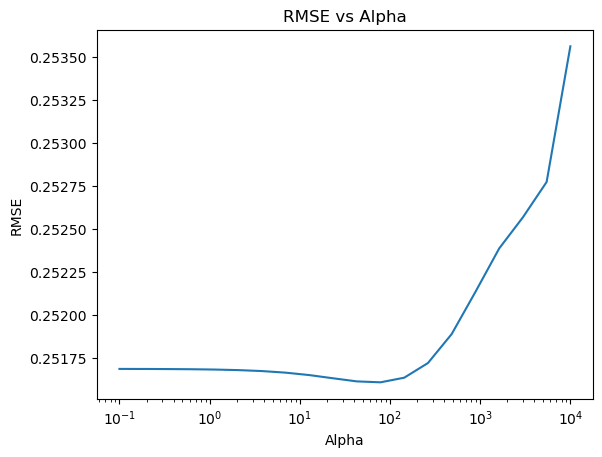

R2 Score: 0.5614300035573794
Best Alpha: 78.47599703514607
Best RMSE: 0.2516056315698996


In [47]:
alphas = np.logspace(-1, 4, num=20)
rmse_scores = []
r2_scores = []

for alpha in alphas:
    model_2 = ridgeregCV(alpha=alpha)
    model_2.fit(X_train, Y_train)
    y_pred = model_2.predict(X_test)

    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    rmse_scores.append(rmse)
    
    r2 = r2_score(Y_test, y_pred)
    r2_scores.append(r2)

plt.plot(alphas, rmse_scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.show()

best_alpha_idx = np.argmin(rmse_scores)
best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores[best_alpha_idx]
best_r2 = r2_scores[best_alpha_idx]

print("R2 Score:", r2)
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

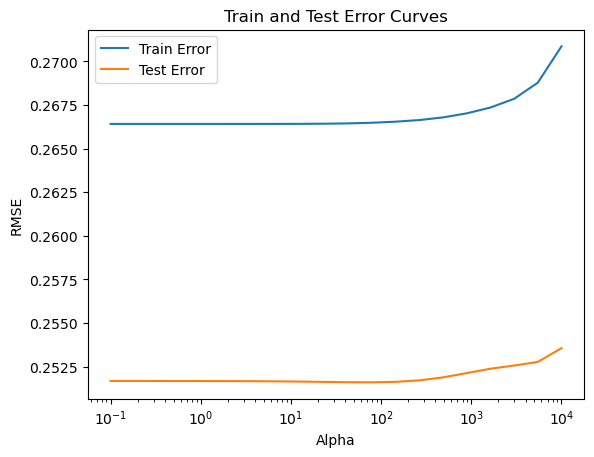

In [48]:
train_errors=[]
test_errors=[]

for alpha in alphas:
    model = ridgeregCV(alpha=alpha)
    model.fit(X_train, Y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    test_error = np.sqrt(mean_squared_error(Y_test, y_test_pred))

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.plot(alphas, train_errors, label='Train Error')
plt.plot(alphas, test_errors, label='Test Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Train and Test Error Curves')
plt.legend()
plt.show()

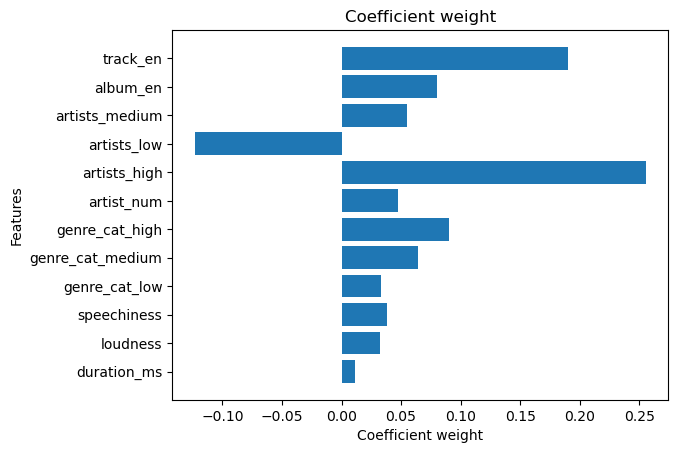

Best Alpha: 78.47599703514607
Best RMSE: 0.2516056315698996


In [49]:
best_model = ridgeregCV(alpha=best_alpha)
best_model.fit(X, Y)

feature_names = df3.columns[1:]
coef = best_model.coef_

plt.barh(feature_names, coef)
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.title('Coefficient weight')
plt.show()

print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

## Model 4: Only categorical variables+ CV

In [50]:
df4 = df3.drop(['duration_ms','loudness', 'speechiness'], axis =1)
X = df4.iloc[:, 1:].values
Y = df4.iloc[:, 0].values
ratio = 0.7
total_rows = X.shape[0]
train_size = int(total_rows * ratio)

X_train = X[0:train_size]
X_test = X[train_size:]
total_rows2 = Y.shape[0]
train_size2 = int(total_rows2 * ratio)

Y_train = Y[0:train_size2]
Y_test = Y[train_size2:]

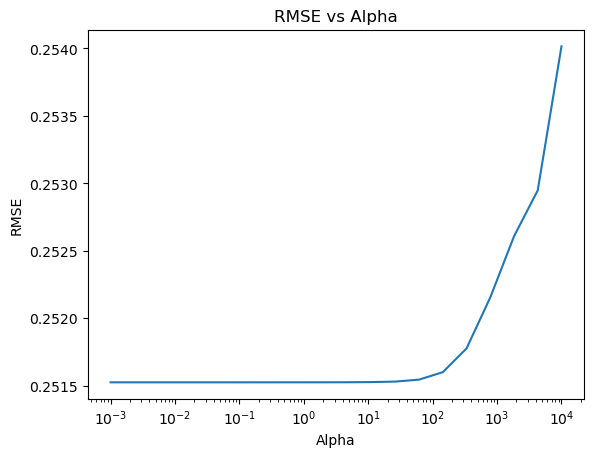

R2 Score: 0.5598647288159866
Best Alpha: 0.002335721469090121
Best RMSE: 0.25152366718489344


In [51]:
alphas = np.logspace(-3, 4, num=20)
rmse_scores = []
r2_scores = []

for alpha in alphas:
    model_3 = ridgeregCV(alpha=alpha)
    model_3.fit(X_train, Y_train)
    y_pred = model_3.predict(X_test)

    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    rmse_scores.append(rmse)
    
    r2 = r2_score(Y_test, y_pred)
    r2_scores.append(r2)

plt.plot(alphas, rmse_scores)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.show()

best_alpha_idx = np.argmin(rmse_scores)
best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores[best_alpha_idx]
best_r2 = r2_scores[best_alpha_idx]

print("R2 Score:", r2)
print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

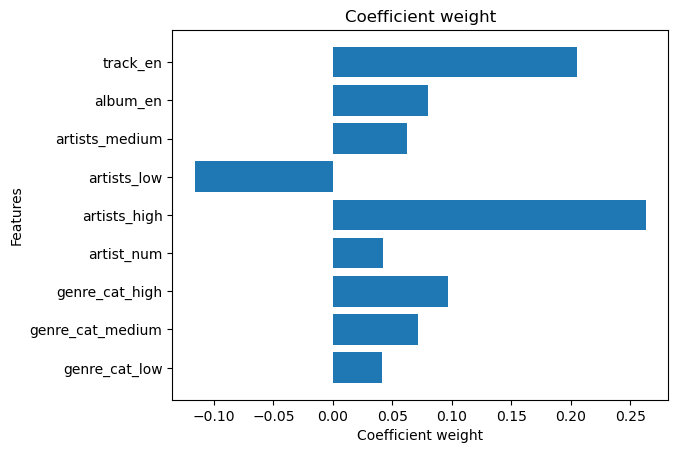

Best Alpha: 0.002335721469090121
Best RMSE: 0.25152366718489344


In [52]:
best_model = ridgeregCV(alpha=best_alpha)
best_model.fit(X, Y)

feature_names = df4.columns[1:]
coef = best_model.coef_

plt.barh(feature_names, coef)
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.title('Coefficient weight')
plt.show()

print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

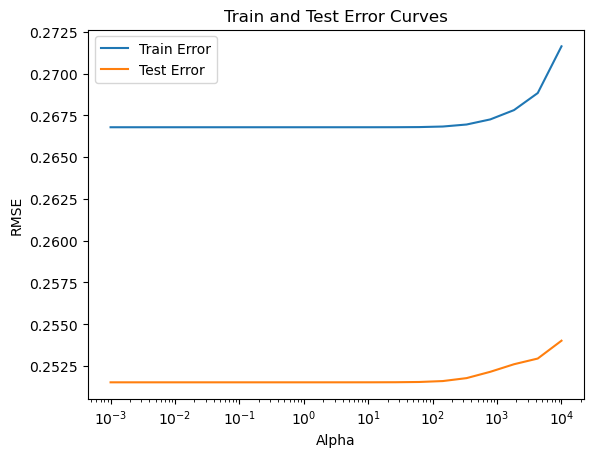

In [53]:
train_errors=[]
test_errors=[]

for alpha in alphas:
    model = ridgeregCV(alpha=alpha)
    model.fit(X_train, Y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    test_error = np.sqrt(mean_squared_error(Y_test, y_test_pred))

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.plot(alphas, train_errors, label='Train Error')
plt.plot(alphas, test_errors, label='Test Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Train and Test Error Curves')
plt.legend()
plt.show()

## Using Grid search with categorical and numerical variables

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.base import BaseEstimator, RegressorMixin

In [55]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

class ridgereg2(BaseEstimator, RegressorMixin):
    def __init__(self, alpha):
        self.alpha = alpha
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

        XtX = np.dot(X.T, X)
        n = X.shape[1]
        self.coef_ = np.dot(np.linalg.inv(XtX + self.alpha * np.eye(n)), np.dot(X.T, y))
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]

        return self

    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        return np.dot(X, np.concatenate(([self.intercept_], self.coef_)))
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

In [56]:
alphas = np.logspace(-1, 5, num=20)
model = ridgereg2(alpha=alphas)

param_grid = {'alpha': alphas}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['alpha']
coefficients = grid_search.best_estimator_.coef_
intercept = grid_search.best_estimator_.intercept_

y_pred = grid_search.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("Best Alpha:", best_alpha)
print("RMSE:", rmse)
print("R2 Score:", r2)

Best Alpha: 297.6351441631316
RMSE: 0.26173571881952856
R2 Score: 0.5956540732062121


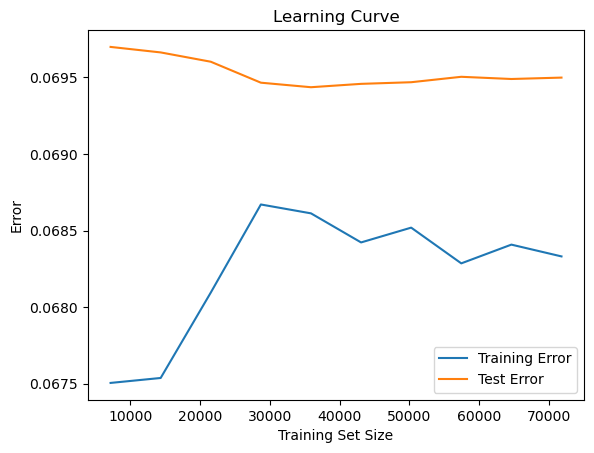

In [57]:
train_sizes, train_scores, test_scores = learning_curve(
    grid_search, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='neg_mean_squared_error', shuffle=True, random_state=42)

train_errors = -np.mean(train_scores, axis=1)
test_errors = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_errors, label='Training Error')
plt.plot(train_sizes, test_errors, label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Grid Search - only encoded categorical variables

In [58]:
X = df4.iloc[:, 1:].values
y = df4.iloc[:, 0].values

class ridgereg2(BaseEstimator, RegressorMixin):
    def __init__(self, alpha):
        self.alpha = alpha
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

        XtX = np.dot(X.T, X)
        n = X.shape[1]
        self.coef_ = np.dot(np.linalg.inv(XtX + self.alpha * np.eye(n)), np.dot(X.T, y))
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]

        return self

    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        return np.dot(X, np.concatenate(([self.intercept_], self.coef_)))
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)


In [59]:
alphas = np.logspace(-1, 5, num=20)
model = ridgereg2(alpha=alphas)

param_grid = {'alpha': alphas}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['alpha']
coefficients = grid_search.best_estimator_.coef_
intercept = grid_search.best_estimator_.intercept_

y_pred = grid_search.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("Best Alpha:", best_alpha)
print("RMSE:", rmse)
print("R2 Score:", r2)

Best Alpha: 16.23776739188721
RMSE: 0.26208935190785954
R2 Score: 0.5945607054611617


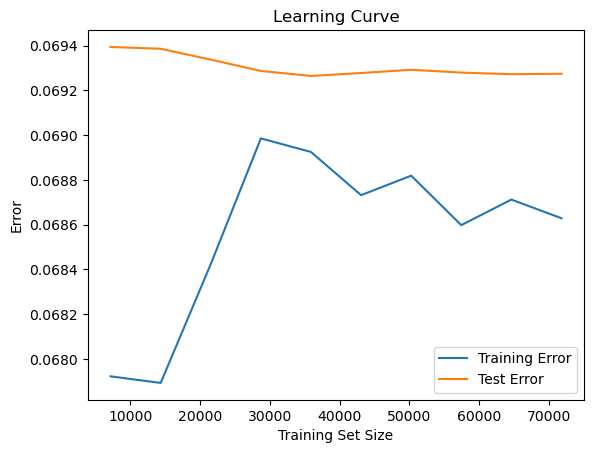

In [60]:
train_sizes, train_scores, test_scores = learning_curve(
    grid_search, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='neg_mean_squared_error', shuffle=True, random_state=42)

train_errors = -np.mean(train_scores, axis=1)
test_errors = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_errors, label='Training Error')
plt.plot(train_sizes, test_errors, label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend()
plt.show()